### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Region growing**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228

### Importing Libraries <a class="anchor" id="libraries" ></a>

In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from PIL import Image
from pydantic import BaseModel, Field, validator
from typing import Any, List, Tuple

In [2]:
class RGBImage():
    # 3D list (height, width, RGB channels)
    image: List[List[List[int]]]

class GrayscaleImage(BaseModel):
    # 2D list (grayscale)
    image: List[List[int]]  

    def to_ndarray(self) -> np.ndarray:
        """Convert Pydantic model back to NumPy array."""
        return np.array(self.image, dtype=np.uint8)
        
class ImageNoise(BaseModel):
    image: GrayscaleImage = Field(..., description="NdArray Image")
    sigma: float = Field(..., description="Gaussian sigma value")
    mu: float = Field(..., description="")
    
class Seeds(BaseModel):
    coordinates: Tuple[int, int] = Field(..., description="(x, y) coordinates to define the seed")
    seed_size: int = Field(..., description="Size of seed")

class RegionSeeds(BaseModel):
    image: GrayscaleImage = Field(..., description="NdArray Image")
    region_seed: List[Seeds] = Field(..., description="List of seeds from an specifique region")

class RegionMasks(BaseModel):
    mask: List[List[float]] = Field(..., description="2D array representing the region mask")

class RGBRegions(BaseModel):
    r: int = Field(..., ge=0, le=255, description="Red component (0-255)")
    g: int = Field(..., ge=0, le=255, description="Green component (0-255)")
    b: int = Field(..., ge=0, le=255, description="Blue component (0-255)")
    
class Regions(BaseModel):
    image: GrayscaleImage = Field(..., description="NdArray Image")
    name: List[str] = Field(..., description="Region name")
    region_color: List[RGBRegions] = Field(..., description="Color assigned to the region in RGB Format")
    region_mask: List[RegionMasks]

### Region Growing Algorithm

In [3]:
class RegionGrowing():
    def __init__(self):
        pass
    
    def apply_noise(self, image, mu = 0, sigma=0.1):
        noise = np.random.normal(mu, sigma, image.shape)
        return image + noise
    
    def __call__(self, seed, image, threshold, dist=4, max_it = 1e6):
        x0, y0 = seed
        mask = np.zeros(image.shape)
        visited_pixels = np.zeros(image.shape)
        N, M = image.shape
        stack = []
        stack.append((x0, y0))
        it = 0
        while len(stack) > 0:
            x0, y0 = stack.pop()
            neighbours = self._N4(x0, y0, M,N) if dist == 4  else self._N8(x0, y0, M, N)
            for x1, y1 in neighbours:
                if self._distance(x0, y0, x1, y1, image) <= threshold and mask[y1,x1] == 0 and visited_pixels[y1, x1] == 0:
                    stack.append((x1, y1))
            mask[y0, x0] = 1
            visited_pixels[y0, x0] = 1
            it = it + 1
            if it > max_it:
                print("overgrowing")
                break
        return mask

    def _distance(self, x0, y0, x1, y1, image):
        v0 = image[y0, x0]
        v1 = image[y1, x1]
        return abs(v1 - v0)

    def _N4(self, x0, y0, M, N):
        # List to store neighbours
        neighbours = []

        # 4-connected neighbours (horizontal and vertical)
        if x0 + 1 < M:
            # Bottom
            neighbours.append((x0 + 1, y0))
        if 0 < x0 - 1:
            # Top
            neighbours.append((x0 - 1, y0))
        if y0 + 1 < N:
            # Right
            neighbours.append((x0, y0 + 1))
        if 0 < y0 - 1:
            # Left
            neighbours.append((x0, y0 - 1))
        
        # return neighbours
        return neighbours

    def _N8(self, x0, y0, M, N):
        # horizontal an vertical neighbours
        neighbours = self._N4(x0, y0, M, N)
        
        # 4 additional diagonal neighbors
        if x0 + 1 < M and y0 + 1 < N:
            # Bottom-right
            neighbours.append((x0 + 1, y0 + 1))
        if x0 + 1 < M and 0 < y0 - 1:
            # Bottom-left
            neighbours.append((x0 + 1, y0 - 1))
        if 0 < x0 - 1 and y0 + 1 < N:
            # Top-right
            neighbours.append((x0 - 1, y0 + 1))
        if 0 < x0 - 1 and 0 < y0 - 1:
            # Top-left
            neighbours.append((x0 - 1, y0 - 1))
            
        # return neighbours
        return neighbours
    
    def set_seed(self, image, seed, seed_size=2):
        xx, yy = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
        x0, y0 = seed

        # draw a circle around the seed
        flag = np.zeros(image.shape)
        flag[((xx - x0)**2 + (yy - y0)**2) < seed_size**2] = 125
        
        return image + flag

### plot images method

In [4]:
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray", hideAxis=True):
    """
    Plots a list of images in a grid layout using Matplotlib.

    Parameters:
    images (list): List of images to be plotted.
    labels (list): List of labels for each image. Default is an empty list.
    nrows (int): Number of rows in the grid. Default is 1.
    ncols (int): Number of columns in the grid. Default is 2.
    figsize (tuple): Size of the figure in inches. Default is (12, 8).
    cmap (str): Colormap to be used for displaying the images. Default is "gray".

    Returns:
    None
    """
    if len(images) > 1:
        # set the subplots
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
        # Iterate over each axis defined in M*N as flat
        for i, ax in enumerate(axs.flat):
            # validates that the dimensions of axs fits with images array parameter
            if i < len(images):
                # plot the image
                ax.imshow(images[i], cmap=cmap)
                # if there are labels defined then set a title
                if len(labels) > 0:
                    ax.set_title(labels[i])
                # dont show the axis ticks
                if hideAxis:
                    ax.axis("off")
            else:
                # dont show an empty plot
                ax.axis("off")
    else:
        plt.figure(figsize=figsize)
        plt.imshow(images[0], cmap=cmap)
        if len(labels) > 0:
            # Display width and height in the title
            plt.title(labels[0])  
        if hideAxis:
            plt.xticks([])
            plt.yticks([])
    # fits the plots
    plt.tight_layout()
    plt.show()

## Instance of Region Growing class

In [6]:
regionGrowing = RegionGrowing()

## Creating an image to test region growing

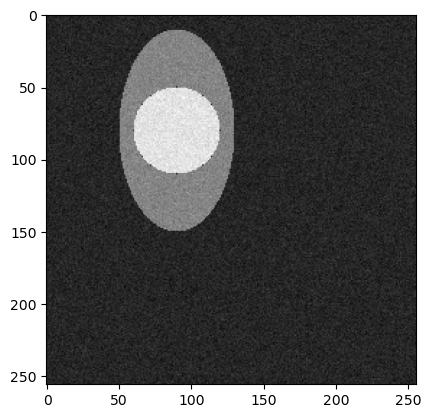

In [7]:
xx, yy = np.meshgrid(np.arange(256), np.arange(256))
img = np.zeros((256, 256))

rr0 = (xx-90)**2 + (yy-80)**2
img[rr0 < 30**2] = 20.0

# contiguous region
rr1 = (xx-90)**2/40**2 + (yy-80)**2/70**2
img[(rr0 > 30.0**2)*(rr1 < 1.0)] = 10.0

img = regionGrowing.apply_noise(image=img, sigma=1)

plt.imshow(img, cmap="gray")

### Define a seed in the image

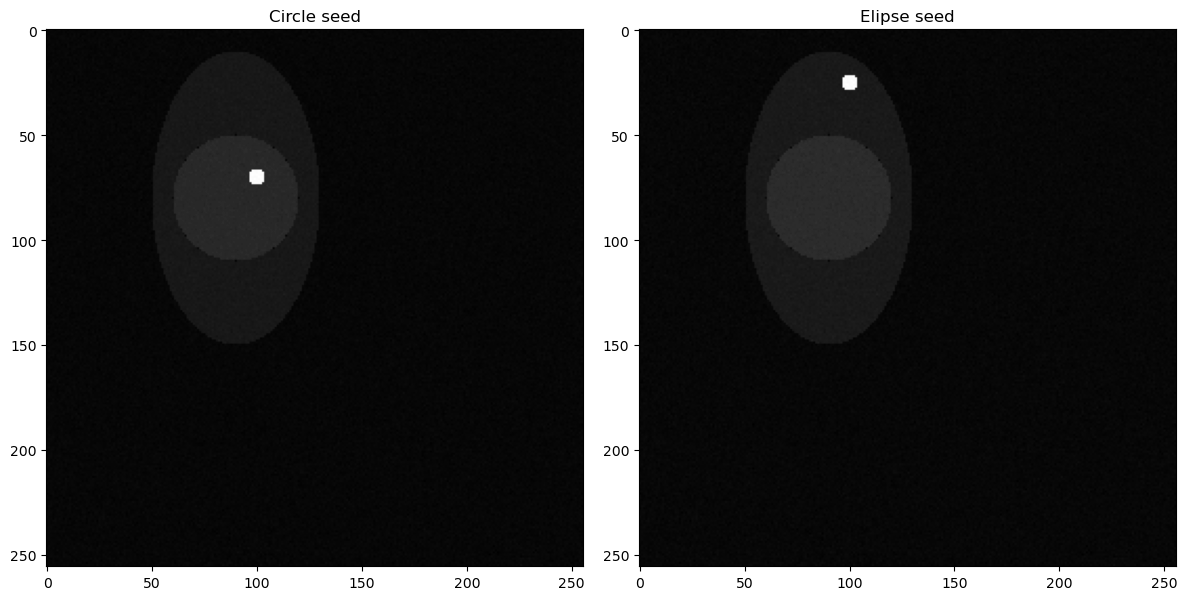

In [8]:
# using a sedd
circle_seed = (100, 70)
elipse_seed = (100, 25)

# draw a circle around the seed
circle_flag =  regionGrowing.set_seed(image=img, seed=circle_seed, seed_size=4)
elipse_flag =  regionGrowing.set_seed(image=img, seed=elipse_seed, seed_size=4)

labels = ["Circle seed", "Elipse seed"]

plot_images([circle_flag, elipse_flag], labels, hideAxis=False)

### Plot the region

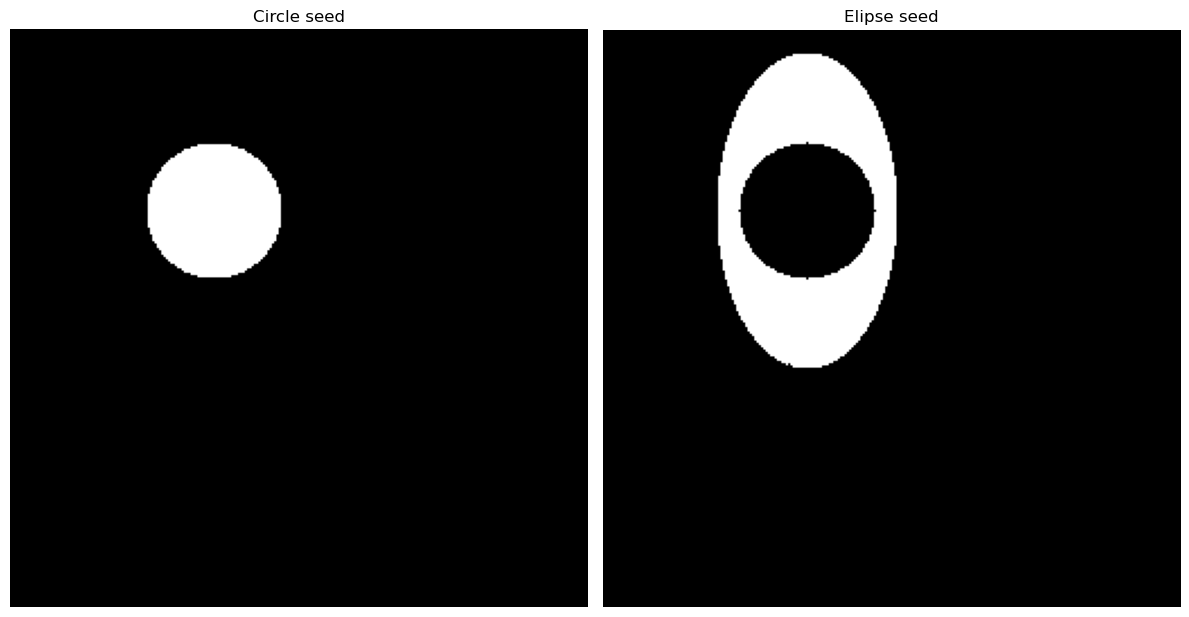

In [9]:
circle_mask = regionGrowing(seed=circle_seed, image=img, threshold=4)
elipse_mask = regionGrowing(seed=elipse_seed, image=img, threshold=4)

plot_images([circle_mask, elipse_mask], labels)

## Region growing in medical imaging

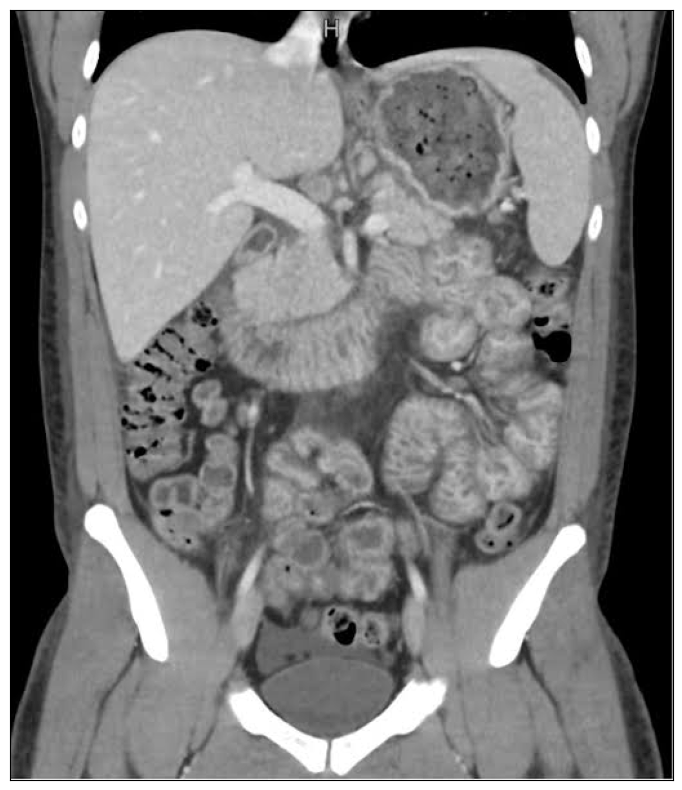

In [100]:
corp_image = cv2.imread("data/corps.JPG")

gray_corps_image = cv2.cvtColor(corp_image, cv2.COLOR_BGR2GRAY)

plot_images([gray_corps_image])

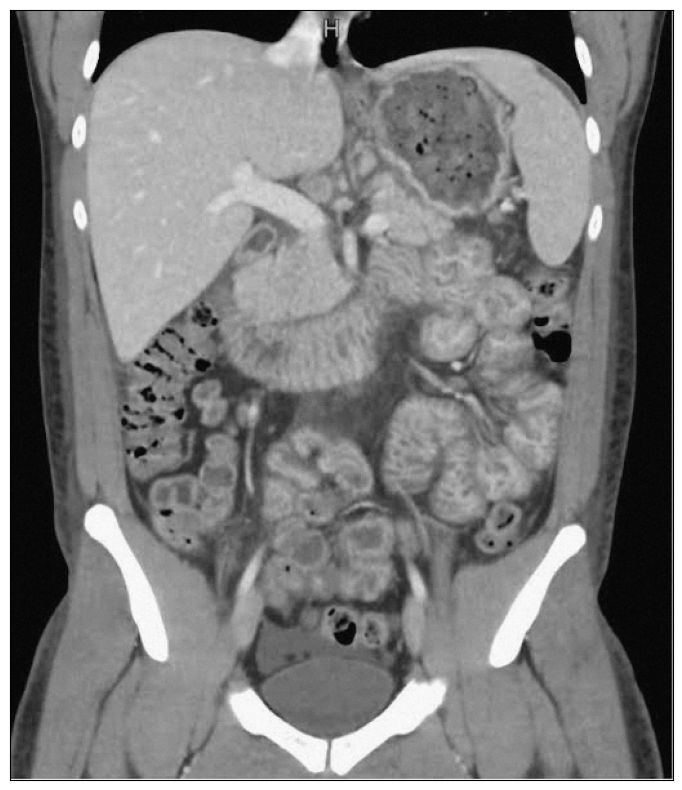

In [112]:
gray_corps_image = regionGrowing.apply_noise(image=gray_corps_image, sigma=1.5)

plot_images([gray_corps_image])

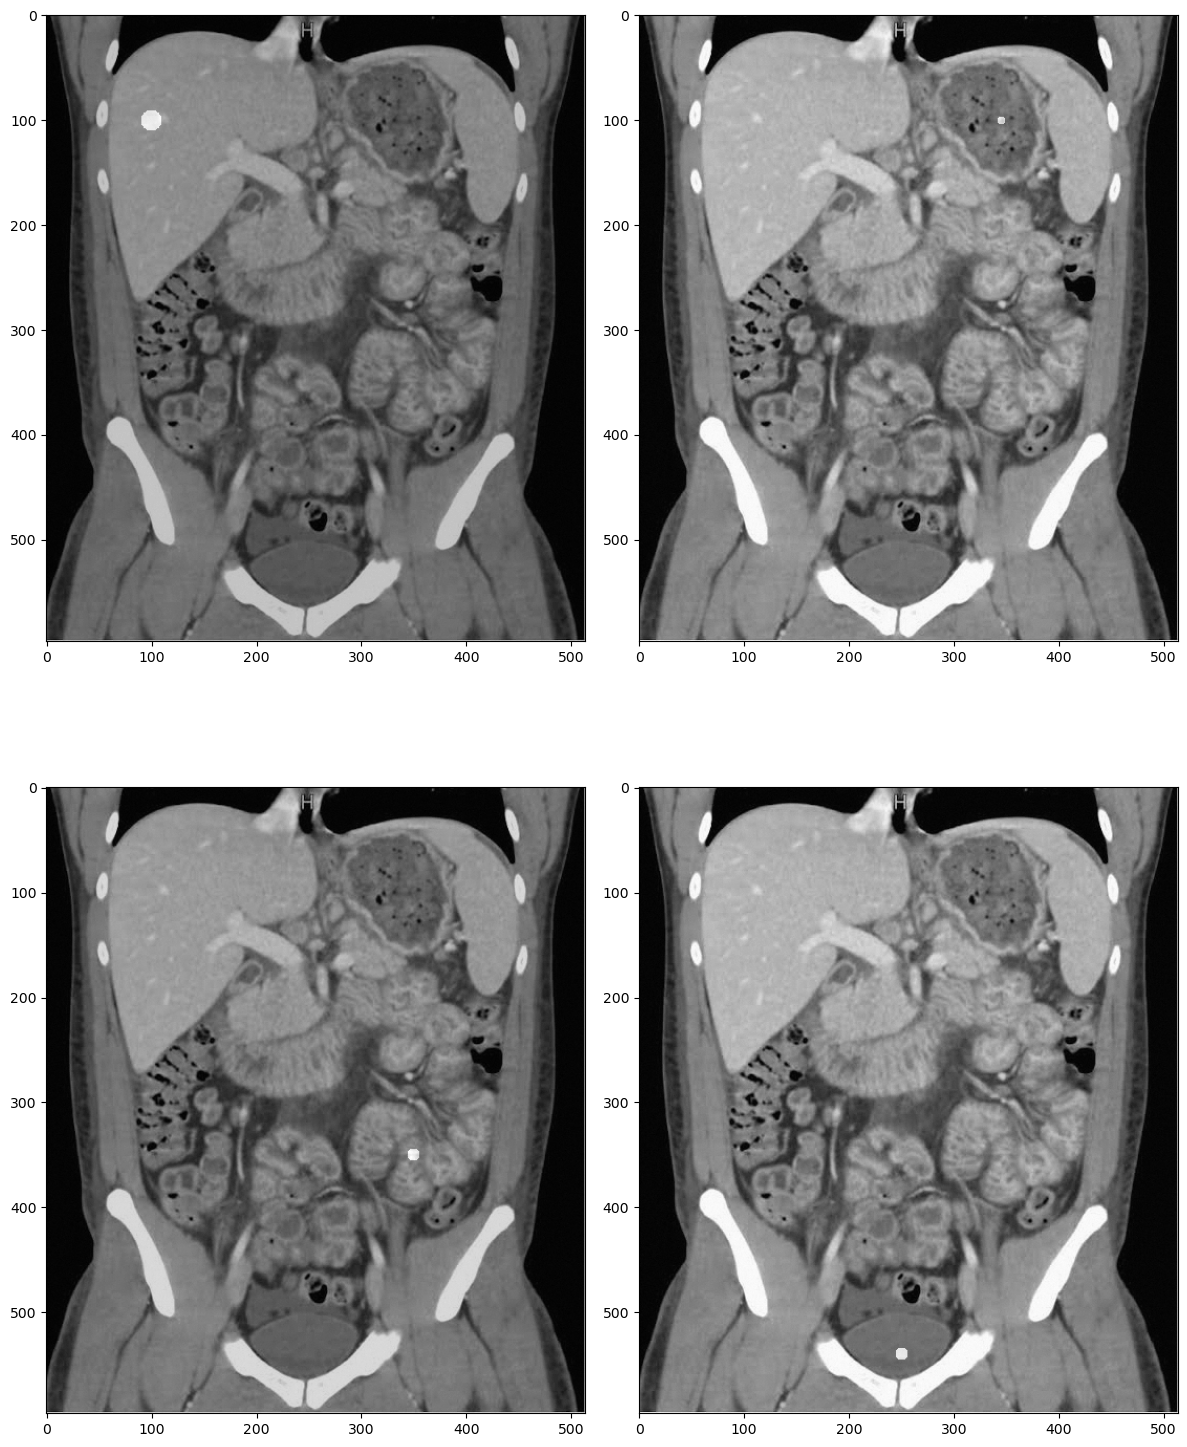

In [102]:
corps_seed = (100, 100)
corps_seed2 = (345,100)
corps_seed3 = (350, 350)
corps_seed4 = (250,540)

seed_img1 = regionGrowing.set_seed(gray_corps_image, corps_seed, 10)
seed_img2 = regionGrowing.set_seed(gray_corps_image, corps_seed2, 4)
seed_img3 = regionGrowing.set_seed(gray_corps_image, corps_seed3, 6)
seed_img4 = regionGrowing.set_seed(gray_corps_image, corps_seed4, 6)

plot_images([seed_img1, seed_img2, seed_img3, seed_img4], hideAxis=False, figsize=(12,16), ncols=2, nrows=2)

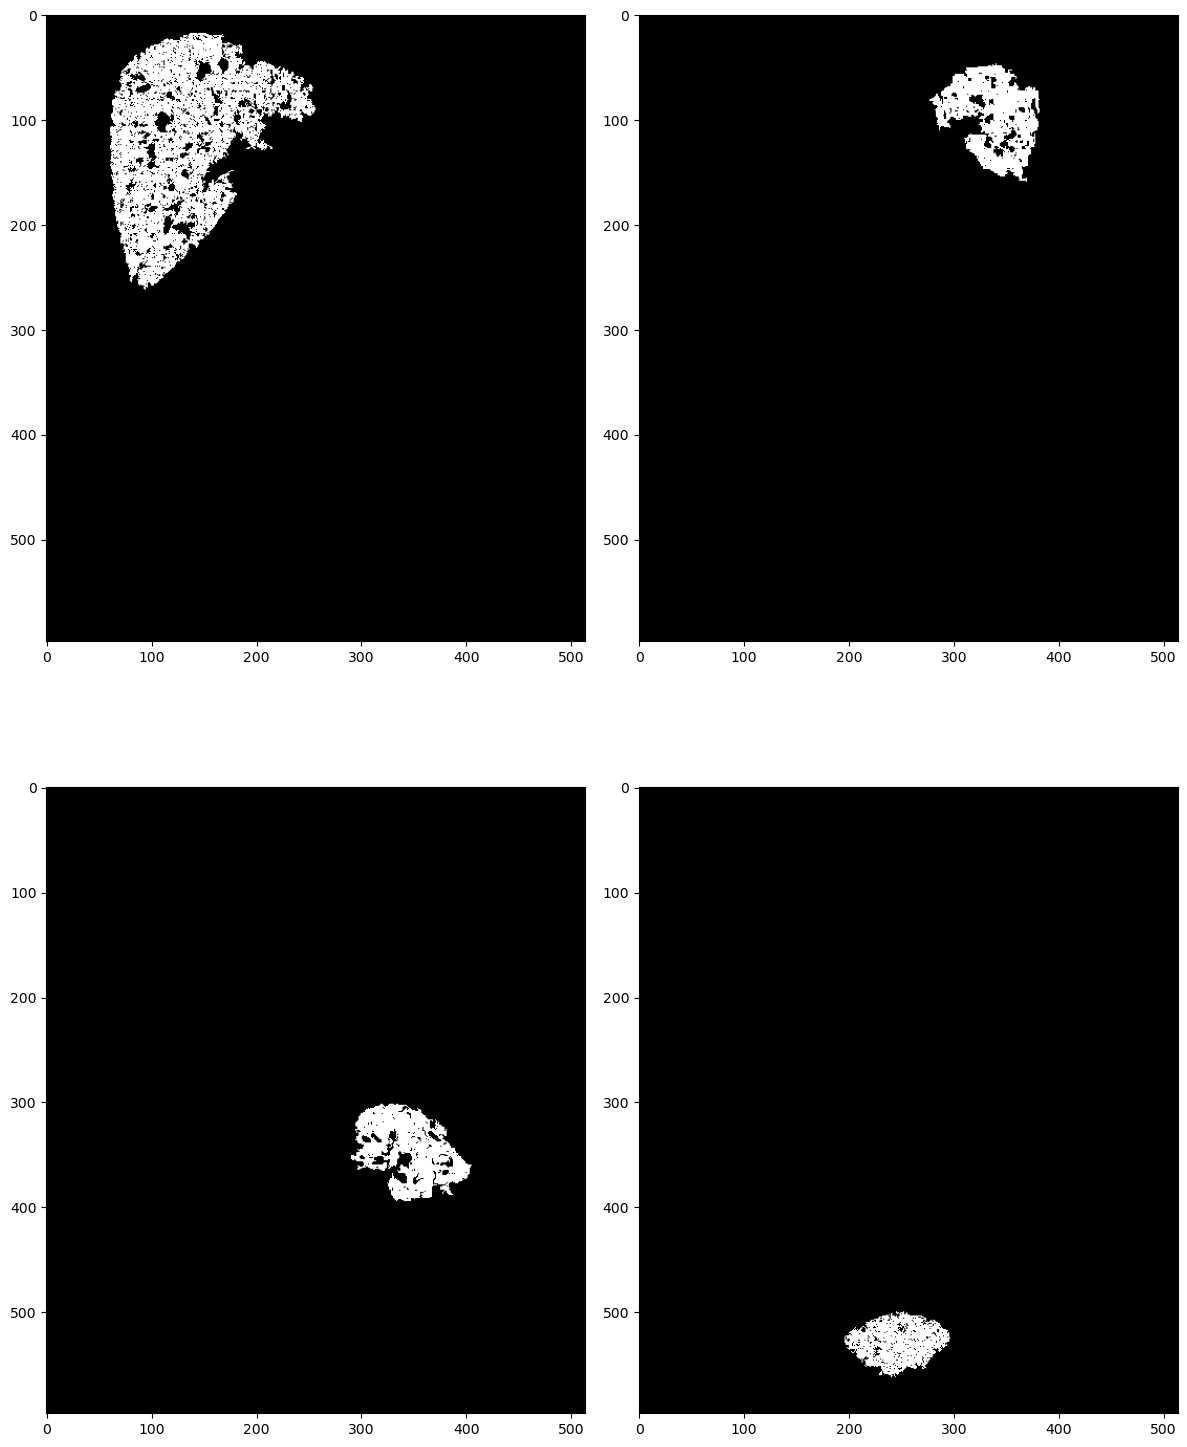

In [113]:
corps_mask = regionGrowing(seed=corps_seed, image=gray_corps_image, threshold=2, dist=8)
corps_organ_mask2 = regionGrowing(seed=corps_seed2, image=gray_corps_image, threshold= 5, dist=4)
corps_organ_mask3 = regionGrowing(seed=corps_seed3, image=gray_corps_image, threshold= 4, dist=8)
corps_organ_mask4 = regionGrowing(seed=corps_seed4, image=gray_corps_image, threshold= 2, dist=8)

plot_images([corps_mask, corps_organ_mask2, corps_organ_mask3, corps_organ_mask4], hideAxis=False, figsize=(12,16), ncols=2, nrows=2)

In [115]:
def plot_region_growing(image, masks, colours=None):
    
    if colours is None:
        # genereate random colours for each region if are not provided
        np.random.seed(42)
        colours = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(len(masks))]
        
    # convert image to uint8 if it is necessary
    if image.dtype != np.uint8:
        image = cv2.convertScaleAbs(mask)

    # create an empty colour mask for all regions
    combined_mask = np.zeros_like(image, dtype=np.uint8)
    
    for mask, colour in zip(masks, colours):
        # convert mask to uint8 if it is necessary
        if mask.dtype != np.uint8:
            mask = cv2.convertScaleAbs(mask)
        
        # Create a blank colour mask for this region
        colour_mask = np.zeros_like(image, dtype=np.uint8)
        # fill with the chosen colour
        colour_mask[:] = colour

        # apply the mask to create a coloured region
        region = cv2.bitwise_and(colour_mask, colour_mask, mask=mask)
        # Accumulate the coloured region into the combined mask using bitwise OR
        combined_mask = cv2.bitwise_or(combined_mask, region)

    # merging the combined regions with the original image
    final_image = cv2.addWeighted(image, 1, combined_mask, 0.85, 0)
    
    # final_image = cv2.add(image, combined_mask)
    
    # final_image = np.clip(image + combined_mask, 0, 255).astype(np.uint8)
    
    return final_image

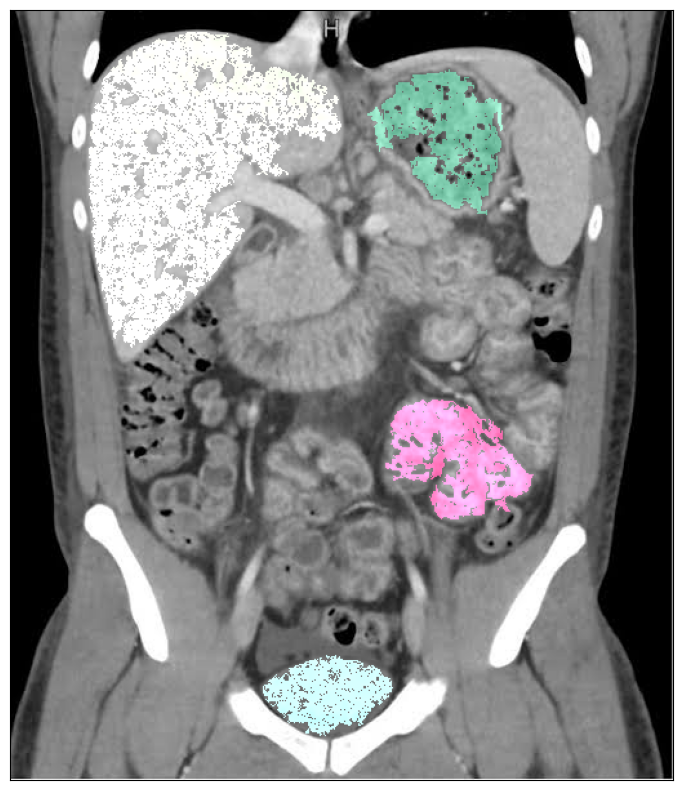

In [116]:
masks = [corps_mask, corps_organ_mask2, corps_organ_mask3, corps_organ_mask4]

final_image = plot_region_growing(image=corp_image, masks=masks)

plot_images([final_image], hideAxis=True)


### References

1. paper
2. DRIVE - Grand Challenge. (n.d.). grand-challenge.org. https://drive.grand-challenge.org/